# Advanced ML - HW4

**Submitted by:**

Yaniv Tal - 031431166

Miryam Horowicz - 313246704

## Flow control parameters

In [1]:
# ENVIRONMENT = 'Local'
ENVIRONMENT = 'Colab'

In [2]:
''' Each parameter can have the values:
  Process - run the process logic and save to disk
  Load - Load saved data from disk
  Disable - Do nothing
'''
SCALER_MODE = 'Load'
LABEL_ENCODER_MODE = 'Load'
TRAIN_MODEL_1 = 'Load'
TRAIN_MODEL_2 = 'Load'
TRAIN_MODEL_FINAL = 'Load'



## General parts - imports, mounts, load data, utility functions etc.

### Imports

In [3]:
%pip install langdetect
# %pip install pandas
# %pip install numpy
# %pip install tqdm
# %pip install matplotlib
# %pip install scikit-learn
# %pip install pytorch
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 13.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=5ba62cd212d1d11c24da8cde9db7bf679a6775ce4e58f21f064171b8e68bbe36
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 14.2 MB/s 
     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 6.6 MB 32.4 MB/s 
     |████████████████████████████████| 596 kB 50.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from pathlib import Path

import json
import pandas as pd
import numpy as np
import string
import datetime
import re

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from os import cpu_count
import pickle

from langdetect import detect
from langdetect import DetectorFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from transformers import DistilBertTokenizerFast
from transformers import AutoConfig, AutoModel
from transformers import DistilBertForSequenceClassification
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import spacy
from nltk import SnowballStemmer


if ENVIRONMENT == 'Colab':
    from google.colab import drive

### Mount drive, set paths

In [5]:
if ENVIRONMENT == 'Colab':
  drive.mount('/content/drive')
  data_path_train = Path('/content/drive/MyDrive/colab_data/aml_hw4/train_data_for_students.tsv')
  path_output = Path('/content/drive/MyDrive/colab_data/aml_hw4/outputs')

elif ENVIRONMENT == 'Local':
  data_path_train = Path('./train_data_for_students.tsv')
  path_output = Path('./outputs')

if not data_path_train.exists():
    raise FileNotFoundError('train data file not found!')

if not path_output.is_dir():
    path_output.mkdir(parents=True, exist_ok=True)


Mounted at /content/drive


## Download data, to initial dataframe

In [6]:
data_train = pd.read_csv(data_path_train, sep='\t', lineterminator='\n', names=('id', 'alias', 'text', 'date_time', 'label'))
print(data_train.head(5))

                   id            alias  \
0  845974102619906048  realDonaldTrump   
1  846166053663191040  realDonaldTrump   
2  835814988686233601  realDonaldTrump   
3  835817351178301440  realDonaldTrump   
4  835916511944523777  realDonaldTrump   

                                                text            date_time  \
0  Democrats are smiling in D.C. that the Freedom...  2017-03-26 15:21:58   
1  General Kelly is doing a great job at the bord...  2017-03-27 04:04:42   
2  The race for DNC Chairman was, of course, tota...  2017-02-26 13:33:16   
3  For first time the failing @nytimes will take ...  2017-02-26 13:42:39   
4  Russia talk is FAKE NEWS put out by the Dems, ...  2017-02-26 20:16:41   

     label  
0   iphone  
1   iphone  
2  android  
3  android  
4  android  


## Data Cleanup

### Drop NA values

In [7]:
print(f'shape before:{data_train.shape}')
data_train.dropna(axis=0, inplace=True)
print(f'shape after:{data_train.shape}')


shape before:(2682, 5)
shape after:(2671, 5)


### Drop irrelevant label rows

In [8]:
data_train = data_train.loc[data_train['label'].isin(['iphone', 'android'])]

### Check data label balance

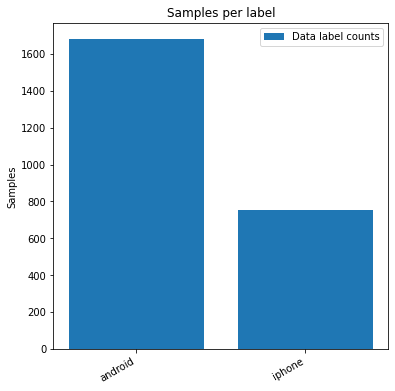

In [9]:
def labels_balance(data: pd.DataFrame, label_name: str):
  '''
  Gets: 
  data - pandas dataframe with attribute values in index, iphone and android columns with counts
  attribute name - string
  '''

  samples_per_label = pd.DataFrame(data[label_name].value_counts())
  samples_per_label.columns=['count']
  samples_per_label['percent'] = samples_per_label['count'].values / sum(samples_per_label['count'])

  
  fig, ax = plt.subplots(figsize=(6, 6))
  x = np.arange(len(samples_per_label))
  bars = ax.bar(x, samples_per_label['count'], label='Data label counts')
  
  ax.set_ylabel('Samples')
  ax.set_title(f'Samples per label')
  ax.set_xticks(x)
  ax.set_xticklabels(samples_per_label.index)

  if ENVIRONMENT == 'local':
    ax.bar_label(bars)

  ax.legend()
  plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
  
  plt.show()

  return(samples_per_label)

samples_per_label = labels_balance(data_train, 'label')


## Utility Functions

### compare attribute distribution android / iphone



In [10]:
def plot_bars_per_label(data: pd.DataFrame, attribute_name: str):
  '''
  Gets: 
  data - pandas dataframe with attribute values in index, iphone and android columns with counts
  attribute name - string
  '''

  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  x = np.arange(len(data.index))
  width = 0.35

  bars_iphone = ax[0].bar(x - width, data['iphone'], width, label='iphone tweets, log scale')
  bars_android = ax[0].bar(x, data['android'] ,width, label='Android tweets, log scale')

  ax[0].set_ylabel('tweets')
  ax[0].set_title(f'tweets per {attribute_name} per origin')

  bar_labels = list(data.index.values)
  ax[0].set_xticks(x)
  ax[0].set_xticklabels(bar_labels)

  ax[0].set_yscale('log')
  ax[0].legend()

# percentage
  data_percentage = pd.DataFrame()
  data_percentage['iphone'] = data['iphone'] / (data['iphone'] + data['android'])
  data_percentage['android'] = data['android'] / (data['iphone'] + data['android'])

  bars_iphone = ax[1].bar(x, data_percentage['iphone'], label='iphone tweets, percent')
  bars_android = ax[1].bar(x, data_percentage['android'], bottom=data_percentage['iphone'], label='Android tweets, percent')

  ax[1].set_ylabel('tweets percent')
  ax[1].set_title(f'tweets percentage per {attribute_name} per origin')

  ax[1].set_xticks(x)
  ax[1].set_xticklabels(bar_labels)
  ax[1].legend()


  plt.show()

### Plot train progress - loss and accuracy

In [11]:
def plot_train_progress(data: pd.DataFrame):

  '''
  Gets: 
  data - pandas dataframe with attribute values in index, iphone and android columns with counts
  attribute name - string
  '''

  fig, ax = plt.subplots(figsize=(6, 6))
  ax_accuracy = ax.twinx()


  train_loss_line = ax.plot(data['epoch'], data['train_loss'], label='Train loss', color='b')
  validation_loss_line = ax.plot(data['epoch'], data['validation_loss'], label='Validation loss', color='r')
  validation_accuracy_line = ax_accuracy.plot(data['epoch'], data['validation_accuracy'], label='Validation accuracy', color='y')

  ax.set_ylabel('loss')
  ax_accuracy.set_ylabel('Accuracy')
  ax.set_title(f'Train progress per epoch')

  ax.legend()
  ax_accuracy.legend()

  plt.show()

## Feature Engineering
* Style based attributes:
  1. Has "Dumb retweets" - Boolean
  2. number of capital letters in tweet
  3. Contains URLs - Boolean
  5. Language - category string
  6. Hashtag count in text - int

* Time based attributes:
  1. Hour of day
  2. Minutes of day
  3. day of week
  4. day of month
  5. Month
  6. Year



In [12]:
SEED = 1234

# random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Function definitions for attribute engineering

#### Add language attribute

In [13]:
# Language detection
def get_string_language(string):
    """Gets the languages of each paper using fancy machine-learning"""
    try:
        return detect(''.join(string[:min(len(string), 50)]))
    except:       
        # Defaulting to English if failed to detect
        return 'en'
  

def get_text_language(texts):
  DetectorFactory.seed = 123
  langs = pd.Series(texts).progress_apply(get_string_language)
  return langs

#### Add "quote retweets" attribute

In [14]:
# quote retweet detection
def is_quote_retweet(string):
    """returns boolean - contains quote retweet True / False"""
    search_exp = '^@.*".*"'
    return not (re.search(search_exp, string) is None)


def get_text_quote_retweets(texts):
  quote_retweets = pd.Series(texts).progress_apply(is_quote_retweet)
  return quote_retweets

#### Add capital letter count attribute

In [15]:
# count of capital letters
def string_percent_caps(string):
    """returns float - % capital letters"""
    p_caps = sum(1 for c in string if c.isupper()) / len(string)
    return np.round(p_caps, 2)


def get_percent_caps(texts):
  percent_caps = pd.Series(texts).progress_apply(string_percent_caps)
  return percent_caps

#### Add contains url attribute

In [16]:
# url detection
def string_contains_url(string):
    """returns boolean - contains url True / False"""
    search_exp = 'http'
    return not (re.search(search_exp, string) is None)

def get_contains_url(texts):
  contains_url = pd.Series(texts).progress_apply(string_contains_url)
  return contains_url

#### Contains Hashtag attribute

In [17]:
# count of capital letters
def string_hashtag_count(string):
    """returns int - num capital letters"""
    h_count = sum(1 for c in string if c == '#')
    return h_count


def get_hashtag_count(texts):
  hashtag_count = pd.Series(texts).progress_apply(string_hashtag_count)
  return hashtag_count

#### Time based attributes

In [18]:
# date time attributes
def add_row_datetime_atts(row, date_time_col_name):
    """returns int - num capital letters"""
    if row[date_time_col_name] is not np.nan:
        datetime_obj = datetime.datetime.strptime(row[date_time_col_name], "%Y-%m-%d  %H:%M:%S")
        row['year'] = datetime_obj.year
        row['month'] = datetime_obj.month
        row['day'] = datetime_obj.day
        row['hour'] = datetime_obj.hour
        row['minute'] = datetime_obj.minute    
        row['weekday'] = datetime_obj.weekday()
        return row


def add_df_datetime_atts(dataframe, date_time_col_name):
    dataframe = dataframe.progress_apply(add_row_datetime_atts, args=[date_time_col_name], axis=1)
    return dataframe

#### Apply attribute enrichment to dataset

In [19]:
# Add all custom attributes

def add_custom_atts_to_df(dataframe):

  # Language is unreliable - not added. all treated as English 
  # print("Adding language attribute")
  # dataframe['lang'] = get_text_language(dataframe['text'])

  print("Adding quote_retweet attribute")
  dataframe['quote_retweet'] = get_text_quote_retweets(dataframe['text'])

  print("Adding percent_caps attribute")
  dataframe['percent_caps'] = get_percent_caps(dataframe['text'])

  print("Adding contains_url attribute")
  dataframe['contains_url'] = get_contains_url(dataframe['text'])

  print("Adding hashtag_count attribute")
  dataframe['hashtag_count'] = get_hashtag_count(dataframe['text'])

  print("Adding date/time attributes")
  dataframe = add_df_datetime_atts(dataframe, 'date_time')

  return dataframe

### Add attributes to train dataframe

In [20]:
print('Before:')
data_train.head(5)

Before:


id            alias  \
0  845974102619906048  realDonaldTrump   
1  846166053663191040  realDonaldTrump   
2  835814988686233601  realDonaldTrump   
3  835817351178301440  realDonaldTrump   
4  835916511944523777  realDonaldTrump   

                                                text            date_time  \
0  Democrats are smiling in D.C. that the Freedom...  2017-03-26 15:21:58   
1  General Kelly is doing a great job at the bord...  2017-03-27 04:04:42   
2  The race for DNC Chairman was, of course, tota...  2017-02-26 13:33:16   
3  For first time the failing @nytimes will take ...  2017-02-26 13:42:39   
4  Russia talk is FAKE NEWS put out by the Dems, ...  2017-02-26 20:16:41   

     label  
0   iphone  
1   iphone  
2  android  
3  android  
4  android

In [21]:
# Apply enrichment
data_train = add_custom_atts_to_df(data_train)



Adding quote_retweet attribute


  0%|          | 0/2438 [00:00<?, ?it/s]

Adding percent_caps attribute


  0%|          | 0/2438 [00:00<?, ?it/s]

Adding contains_url attribute


  0%|          | 0/2438 [00:00<?, ?it/s]

Adding hashtag_count attribute


  0%|          | 0/2438 [00:00<?, ?it/s]

Adding date/time attributes


  0%|          | 0/2438 [00:00<?, ?it/s]

#### Fix dtypes for all attributes:

In [22]:
# Fix dtypes

print(f'dtypes before: {data_train.dtypes}')
data_train = data_train.astype({'text': 'string', 
                   'date_time': 'object', 
                   'label': 'category', 
                  #  'lang': 'category', 
                   'quote_retweet': 'bool',
                   'percent_caps': 'float32',
                   'contains_url': 'bool',
                   'hashtag_count': 'int16',
                   'year': 'int16',
                   'month': 'int16',
                   'day': 'int16',
                   'hour': 'int16',
                   'minute': 'int16',
                   'weekday': 'category'})
print()
print(f'dtypes after: {data_train.dtypes}')



dtypes before: id                 int64
alias             object
text              object
date_time         object
label             object
quote_retweet       bool
percent_caps     float64
contains_url        bool
hashtag_count      int64
year               int64
month              int64
day                int64
hour               int64
minute             int64
weekday            int64
dtype: object

dtypes after: id                  int64
alias              object
text               string
date_time          object
label            category
quote_retweet        bool
percent_caps      float32
contains_url         bool
hashtag_count       int16
year                int16
month               int16
day                 int16
hour                int16
minute              int16
weekday          category
dtype: object


### Visualize engineered attributes


distribution of attribute quote_retweet:


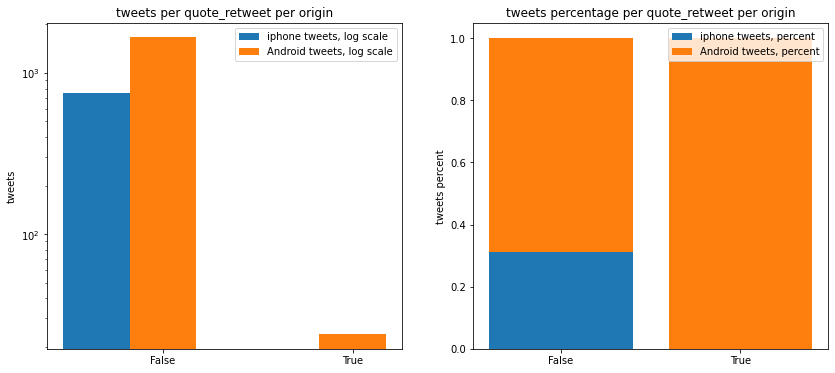


distribution of attribute percent_caps:


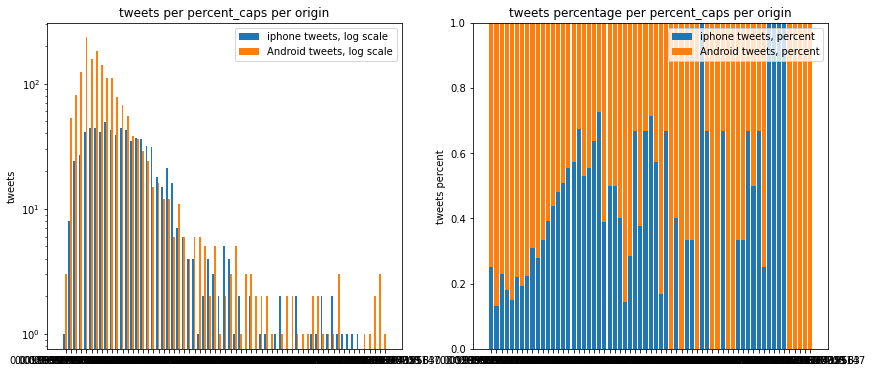


distribution of attribute contains_url:


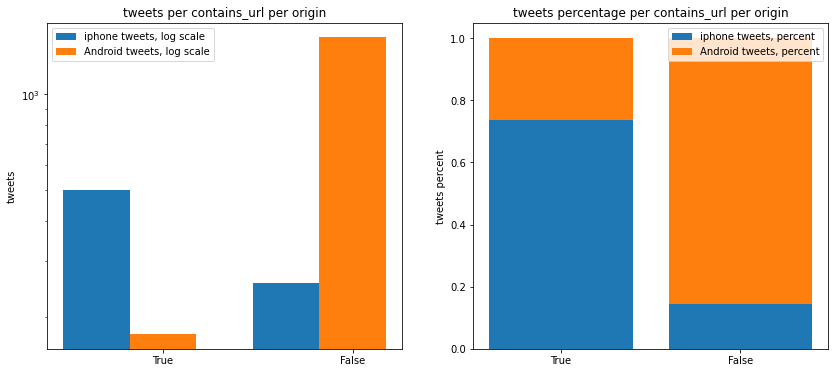


distribution of attribute hashtag_count:


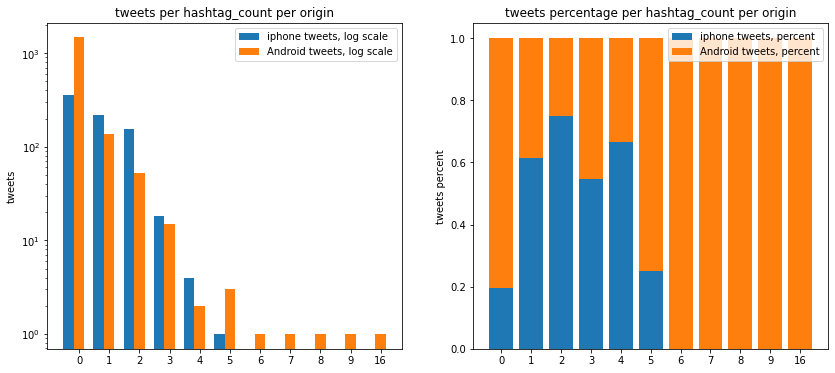


distribution of attribute year:


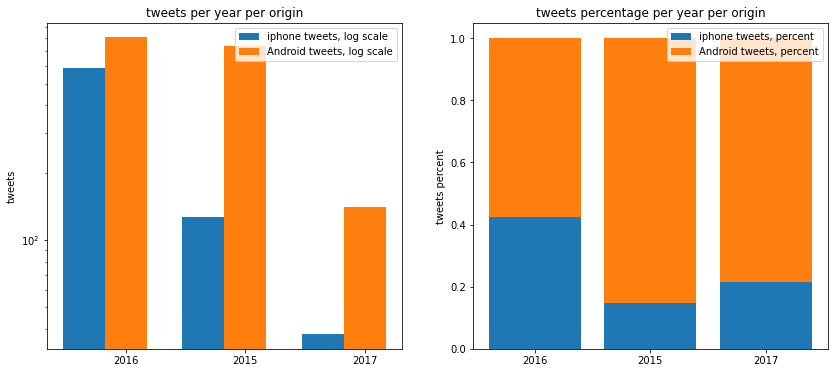


distribution of attribute month:


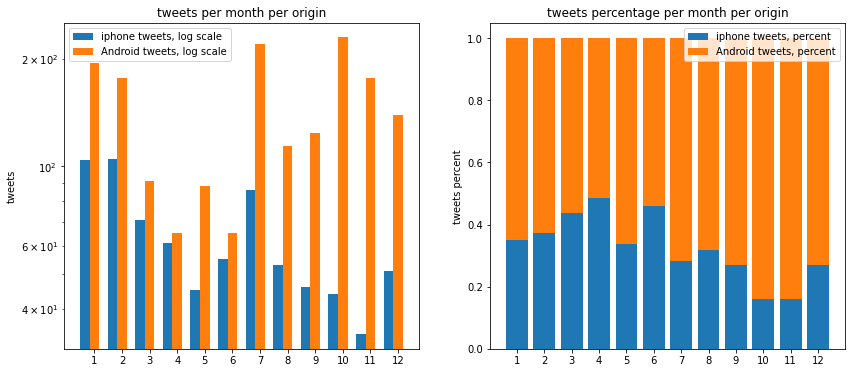


distribution of attribute day:


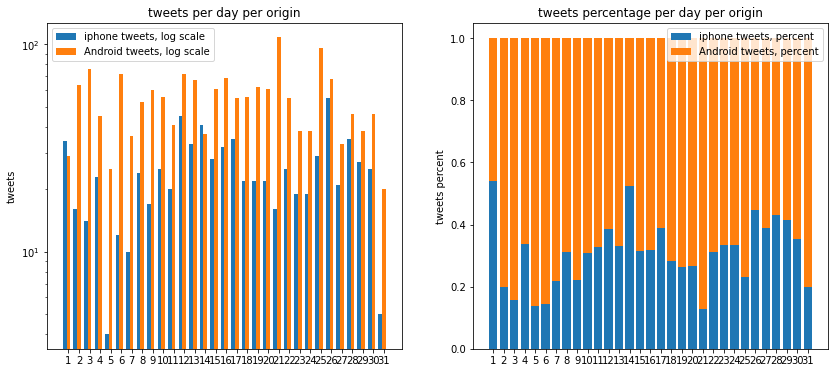


distribution of attribute hour:


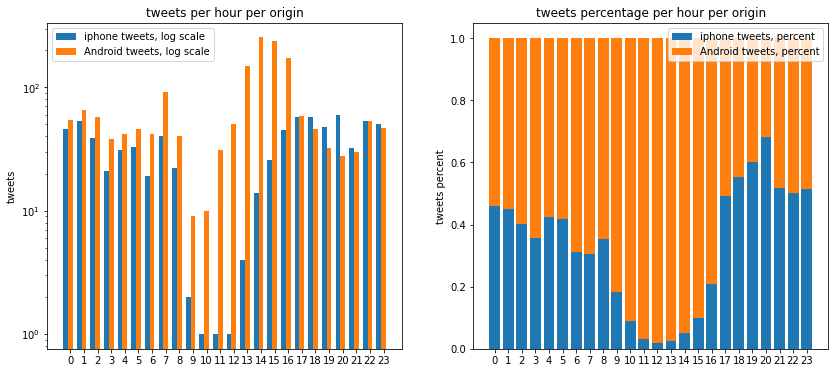


distribution of attribute minute:


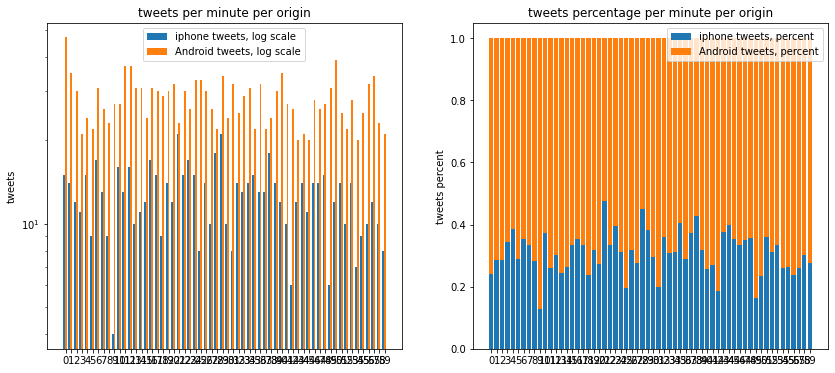


distribution of attribute weekday:


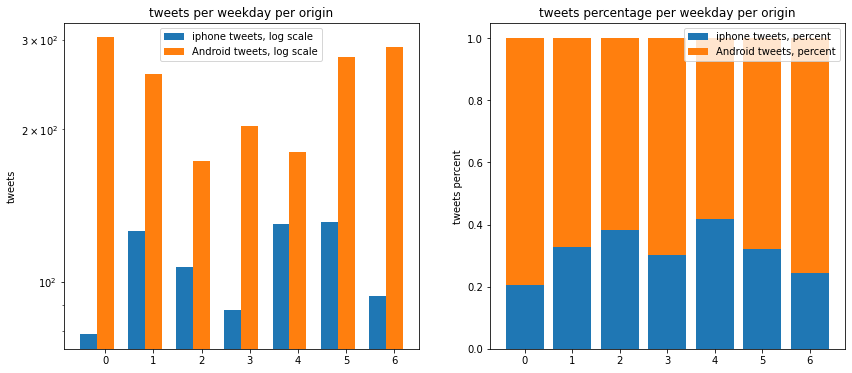

In [23]:
manual_classification_features = list(data_train.columns)
del manual_classification_features[0:5]

for attribute in manual_classification_features:
  print(f'distribution of attribute {attribute}:')

  tweets_per_att_iphone = data_train[data_train.label=='iphone'][attribute].value_counts()
  tweets_per_att_android = data_train[data_train.label=='android'][attribute].value_counts()
  tweets_per_att = pd.concat({'iphone': tweets_per_att_iphone, 'android': tweets_per_att_android}, axis = 1)
  tweets_per_att = tweets_per_att.fillna(0)
  plot_bars_per_label(tweets_per_att, attribute)
  print()


### Create label encoder

In [24]:
labels = data_train.label

data_path = path_output / Path('label_encoder.pickle')

if LABEL_ENCODER_MODE == 'Train':
  print('Label encoder in Train mode')
  label_encoder = preprocessing.LabelEncoder().fit(labels)

  with open(data_path, 'wb') as handle:
    pickle.dump(label_encoder, handle)

elif LABEL_ENCODER_MODE == 'Load':
  print('Label encoder in Load mode')
  with open(data_path, 'rb') as handle:
    label_encoder = pickle.load(handle)


Label encoder in Load mode


### Create feature scaler

In [25]:
from sklearn.preprocessing import MinMaxScaler

data_path = path_output / Path('min_max_scaler.pickle')

manual_classification_features = list(data_train.columns)
del manual_classification_features[0:5]
data_for_classification = data_train[manual_classification_features]

if SCALER_MODE == 'Train':
  print('Scaler in Train mode')
  scaler = MinMaxScaler().fit(data_for_classification)

  with open(data_path, 'wb') as handle:
    pickle.dump(scaler, handle)

elif SCALER_MODE == 'Load':
  print('Scaler in Load mode')
  with open(data_path, 'rb') as handle:
    scaler = pickle.load(handle)

Scaler in Load mode


### Create manual features dataset and label encoder for Pytorch

In [26]:
# Dataset and Dataloader for text features data

class ManualFeaturesDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(self, manual_features_data, labels=None, label_encoder=None):
        if labels is not None:
          assert len(manual_features_data) == len(labels)
        else:
          self.labels = None
        
        self.manual_features_data = manual_features_data
        
        if labels is not None:
          if label_encoder is not None:
            self.label_encoder = label_encoder
          else:
            self.label_encoder = preprocessing.LabelEncoder().fit(labels)
          
          self.labels = pd.Series(self.label_encoder.transform(labels))

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.manual_features_data)

    def __getitem__(self, idx):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """

        if self.labels is not None:
          return torch.tensor(self.manual_features_data.iloc[idx, :]), torch.tensor(self.labels.iloc[idx])
        else:
          return torch.tensor(self.manual_features_data.iloc[idx, :])


In [27]:
# Manual features dataset object creation
# features to include
manual_features_ds = ManualFeaturesDataset(scaler.transform(data_for_classification), labels=labels, label_encoder=label_encoder)


# print(f'data_for_classification shape: {data_for_classification.shape}')
# print(f'data_for_classification sample: {data_for_classification.iloc[0, :]}')

# print(f'len(manual_features_ds): {len(manual_features_ds)}')
# print(f'manual_features_ds sample: {manual_features_ds[0]}')

## Prepare data for language models

### Preprocess text for language model

In [28]:
# preprocess - clean tweets, replace [urls, hashtags, names], update labels to numbers

def preprocess_text_for_bart(string_list):
    preprocessed_text_list = pd.Series(string_list).copy()
    
    # TODO: preprocess here!
    
    return preprocessed_text_list


def add_bart_preprocessed_column_to_df(dataframe):
  dataframe.loc[:, 'text_for_lang_model'] = preprocess_text_for_bart(dataframe.loc[:, 'text'])
  # TODO: need to add cleanup logic here!

  return dataframe


In [29]:

data_train = add_bart_preprocessed_column_to_df(data_train)

data_train.head()

id            alias  \
0  845974102619906048  realDonaldTrump   
1  846166053663191040  realDonaldTrump   
2  835814988686233601  realDonaldTrump   
3  835817351178301440  realDonaldTrump   
4  835916511944523777  realDonaldTrump   

                                                text            date_time  \
0  Democrats are smiling in D.C. that the Freedom...  2017-03-26 15:21:58   
1  General Kelly is doing a great job at the bord...  2017-03-27 04:04:42   
2  The race for DNC Chairman was, of course, tota...  2017-02-26 13:33:16   
3  For first time the failing @nytimes will take ...  2017-02-26 13:42:39   
4  Russia talk is FAKE NEWS put out by the Dems, ...  2017-02-26 20:16:41   

     label  quote_retweet  percent_caps  contains_url  hashtag_count  year  \
0   iphone          False          0.08         False              0  2017   
1   iphone          False          0.03         False              0  2017   
2  android          False          0.07         False              0  2017   
3  android          False          0.01         False              0  2017   
4  android          False          0.07         False              0  2017   

   month  day  hour  minute weekday  \
0      3   26    15      21       6   
1      3   27     4       4       0   
2      2   26    13      33       6   
3      2   26    13      42       6   
4      2   26    20      16       6   

                                 text_for_lang_model  
0  Democrats are smiling in D.C. that the Freedom...  
1  General Kelly is doing a great job at the bord...  
2  The race for DNC Chairman was, of course, tota...  
3  For first time the failing @nytimes will take ...  
4  Russia talk is FAKE NEWS put out by the Dems, ...

### Tokenization

In [30]:
# get only relevant data as lists

def get_texts_and_labels_for_lang_model(dframe, text_col_name, label_col_name):
  return dframe[text_col_name].tolist(), dframe[label_col_name].tolist()


train_texts, train_labels = get_texts_and_labels_for_lang_model(data_train, 'text_for_lang_model', 'label')


In [31]:
# Tokenize texts
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [32]:
len(train_encodings['input_ids'])

2438

### Prepare train datasets and data loaders

In [33]:
# Define datasets with texts and labels

class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(self, encodings, labels = None, label_encoder=None):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
        """
        
        if labels is not None:
          assert len(encodings['input_ids']) == len(labels)
        else:
          self.labels = None
        
        self.encodings = encodings
        
        if labels is not None:
          if label_encoder is not None:
            self.label_encoder = label_encoder
          else:
            self.label_encoder = preprocessing.LabelEncoder().fit(labels)
          
          self.labels = torch.tensor(self.label_encoder.transform(labels))

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
        # item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = {}
        for key in self.encodings.keys():
            item[key] = torch.tensor(self.encodings[key][idx])
                
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        
        return item



## Classifier model 1 - Bert fine-tuned Transformers classifier

### Create dataset object

In [34]:
# Init:
  # preprocess for transforms - clean tweets, replace [urls, hashtags, names], tokenize text, change to tensor
  # Define datasets and dataloaders (Train, test, validation) with X and labels, ENGLISH only
  # Define model - Bart + classification layer

#Train:
  # Define loss function for classification
  # define optimizer (Adam?)
  # define function train_one_batch?
  # Define function train_one_epoch
  # define function train(num_epochs) with runtime reporting every batch and epoch, save model if better etc.


In [35]:
# Create dataset object:
TRAIN_DATASET_PORTION = 0.8
BATCH_SIZE = 30

full_dataset = TextClassificationDataset(train_encodings, labels=train_labels, label_encoder=label_encoder)
train_dataset_size = round(TRAIN_DATASET_PORTION * len(full_dataset))
validation_dataset_size = len(full_dataset) - train_dataset_size
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [train_dataset_size, validation_dataset_size])

full_dl = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
validation_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)


### Classification Model based on distilbert

In [36]:
# 1 linear layers
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(self, pretrained_model_name: str, num_classes: int = None, dropout: float = 0.3):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)

        self.lang_model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, attention_mask=None, head_mask=None):
        """Compute class probabilities for the input sequence.
        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"

        bert_output = self.lang_model(input_ids=features, attention_mask=attention_mask, head_mask=head_mask)
        seq_output = bert_output[0]  # (bs, seq_len, dim)
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        scores = self.classifier(pooled_output)  # (bs, num_classes)

        return scores

### Fine-tune Bert model for current dataset

In [37]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [38]:
def train_epoch(model, data_loader, optimizer, loss_function):
  model.train(True)
  train_loss = 0.0
  
  for i, batch in tqdm(enumerate(data_loader)):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      optimizer.zero_grad()
      outputs = model(input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
        
  return train_loss


In [39]:
def scores_to_class(scores):
  '''
  Gets a matrix with score per class, returns the class (argmax)
  '''
  
  classes = scores.argmax(axis=1).tolist()
  return classes


def evaluate_results(model, test_dl):
  epoch_loss = 0.0
  truth = []
  predictions = []
  raw_scores = None

  model.train(False)

  # onetime=True

  with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dl)):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs, labels)
      epoch_loss += loss.item()

      truth += labels.tolist()
      predictions += scores_to_class(outputs)

  truth = np.array(truth)
  predictions = np.array(predictions)
 
  total_samples = len(truth)
  count_wrong = np.abs(truth - predictions).sum()
  count_right = total_samples - count_wrong
  accuracy = count_right / total_samples

  return epoch_loss, accuracy


In [40]:
#Train configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

model = BertForSequenceClassification(model_name, num_classes=2)
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)
loss_function = nn.CrossEntropyLoss()



Device: cuda


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
PERFORMANCE_CSV_PATH = path_output / 'classifier1_train.csv' 

if TRAIN_MODEL_1 == 'Train':
  NUMBER_OF_EPOCHS_TO_TRAIN = 20
  PERFORMANCE_CSV_PATH = path_output / 'classifier1_train.csv' 

  results_per_epoch = pd.DataFrame(columns=['epoch', 'train_loss', 'validation_loss', 'validation_accuracy'])
  best_validation_accuracy = 0

  # test initial model performance
  epoch = 0
  print(f'Epoch {epoch}')
  validation_loss, validation_accuracy = evaluate_results(model, validation_dl)
  train_loss = 0
  results_per_epoch = results_per_epoch.append({'epoch': epoch, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
  print(results_per_epoch)
  results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

  # Train loop
  for epoch in tqdm(range(NUMBER_OF_EPOCHS_TO_TRAIN)):
    print(f'Epoch {epoch + 1}')
    train_loss = train_epoch(model, train_dl, optim, loss_function)
    validation_loss, validation_accuracy = evaluate_results(model, validation_dl)
    results_per_epoch = results_per_epoch.append({'epoch': epoch + 1, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
    print(results_per_epoch)
    results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

    # if better model:
    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      model_path = path_output / Path(f'model_classifier1_{int(round(validation_accuracy, 3) * 1000)}.pickle')
      torch.save(model.state_dict(), model_path)

else:
  print('Model load mode')
  MODEL_PATH = path_output / Path('model_classifier1_922.pickle')
  model_state_dict = torch.load(MODEL_PATH)
  model.load_state_dict(model_state_dict)
  results_per_epoch = pd.read_csv(PERFORMANCE_CSV_PATH)


  

Model load mode


### Classifier train performance

In [42]:
results_per_epoch

Unnamed: 0  epoch  train_loss  validation_loss  validation_accuracy
0            0    0.0    0.000000        12.330274             0.319672
1            1    1.0   24.799441         4.583136             0.887295
2            2    2.0   12.194862         3.615743             0.909836
3            3    3.0    5.195765         6.582214             0.909836
4            4    4.0    2.855049         4.509588             0.922131
5            5    5.0    1.936464         9.471314             0.901639
6            6    6.0    1.063428         9.456897             0.907787
7            7    7.0    1.884378         6.241019             0.907787
8            8    8.0    0.606758         7.385151             0.918033
9            9    9.0    0.241650         7.759690             0.920082
10          10   10.0    0.179744         6.975187             0.918033
11          11   11.0    0.124537         7.773878             0.922131
12          12   12.0    0.064239         8.105937             0.920082
13          13   13.0    0.053273         8.191160             0.920082
14          14   14.0    0.043846         8.254863             0.920082
15          15   15.0    0.034542         8.518488             0.920082
16          16   16.0    0.027649         8.500313             0.918033
17          17   17.0    0.022317         8.890158             0.918033
18          18   18.0    0.038824         8.340571             0.911885
19          19   19.0    0.097489         8.779632             0.922131
20          20   20.0    0.059379         8.607903             0.915984

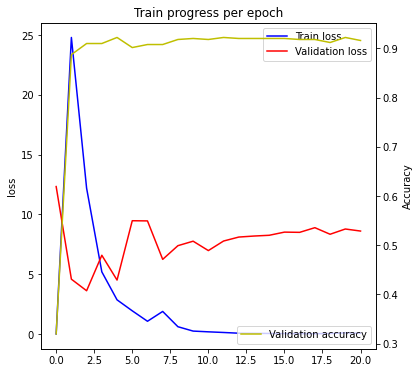

In [43]:
plot_train_progress(results_per_epoch)

## Classifier model 2 - MLP with Bert + manual engineered features


In [44]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_accumulated_memory_stats()

### Prepare dataset

#### Unified dataset - Text and attributes

In [45]:
# Define datasets with texts and labels

class TextAndAttributesClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(self, text_dataset, atts_dataset, labels = None, label_encoder=None):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
        """
        
        assert len(text_dataset) == len(atts_dataset)

        if labels is not None:
          assert len(atts_dataset) == len(labels)
        else:
          self.labels = None
        
        self.text_dataset = text_dataset
        self.atts_dataset = atts_dataset

        if labels is not None:
          if label_encoder is not None:
            self.label_encoder = label_encoder
          else:
            self.label_encoder = preprocessing.LabelEncoder().fit(labels)
          
          self.labels = torch.tensor(self.label_encoder.transform(labels))

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.atts_dataset)

    def __getitem__(self, idx):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
                
        if self.labels is not None:
          return {'text_encodings': self.text_dataset[idx], 'features': self.atts_dataset[idx], 'labels': self.labels[idx]}
        
        else:
          return {'text_encodings': self.text_dataset[idx], 'features': self.atts_dataset[idx]}



In [46]:
# create datasets and data loaders for train and validation
TRAIN_DATASET_PORTION = 0.8
BATCH_SIZE = 20

# standalone datasets - attributes and text
manual_features_nl_ds = ManualFeaturesDataset(data_for_classification)
text_nl_ds = TextClassificationDataset(train_encodings)

# full dataset
full_unified_ds = TextAndAttributesClassificationDataset(text_nl_ds, manual_features_nl_ds, labels=labels, label_encoder=label_encoder)

# Train / valid split
train_unified_ds_size = round(TRAIN_DATASET_PORTION * len(full_unified_ds))
validation_unified_ds_size = len(full_unified_ds) - train_unified_ds_size
train_unified_ds, validation_unified_ds = torch.utils.data.random_split(full_unified_ds, [train_unified_ds_size, validation_unified_ds_size])

# Data loaders
full_unified_dl = torch.utils.data.DataLoader(full_unified_ds, batch_size=BATCH_SIZE)
train_unified_dl = torch.utils.data.DataLoader(train_unified_ds, batch_size=BATCH_SIZE)
validation_unified_dl = torch.utils.data.DataLoader(validation_unified_ds, batch_size=BATCH_SIZE)

In [47]:
# print(f'full_unified_ds: {len(full_unified_ds)}')
# print(f'full_unified_ds sample: {full_unified_ds[0]}')

# print(f'train_unified_ds: {len(train_unified_ds)}')
# print(f'train_unified_ds sample: {train_unified_ds[0]}')

# for i in full_unified_dl:
#   print(i)
#   break


### Classification Model

In [48]:
# Dropouts added between layers
class BertAndFeaturesForSequenceClassification(nn.Module):
    """
    Combines bert, additional features and classifier layers
    """

    def __init__(self, num_manual_features:int, pretrained_model_name: str, lang_linear_layer_dim:int = 150, num_classes: int = None, dropout: float = 0.3):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)      
        self.num_manual_features = num_manual_features
        self.lang_model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.linear_after_lang = nn.Linear(config.hidden_size, lang_linear_layer_dim)
        self.linear_after_features = nn.Linear(num_manual_features, num_manual_features)
        self.linear_after_concat = nn.Linear(num_manual_features + lang_linear_layer_dim, num_manual_features + lang_linear_layer_dim)
        self.classifier = nn.Linear(num_manual_features + lang_linear_layer_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, features, encodings, attention_mask=None, head_mask=None):
        """Compute class probabilities for the input sequence.
        Args:
            encodings (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        
        assert attention_mask is not None, "attention mask is none"

        # Language + linear branch
        bert_output = self.lang_model(input_ids=encodings, attention_mask=attention_mask, head_mask=head_mask)
        seq_output = bert_output[0]  # (bs, seq_len, dim)
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)

        linear_after_lang_output = self.linear_after_lang(pooled_output) 
        linear_after_lang_output = self.dropout(linear_after_lang_output)

        # attributes branch
        linear_after_features_output = self.linear_after_features(features)
        linear_after_features_output = self.relu(linear_after_features_output)
        linear_after_features_output = self.dropout(linear_after_features_output)

        # Unified branch
        concat_vector = torch.cat([linear_after_lang_output, linear_after_features_output], axis=1)

        linear_after_concat_output = self.linear_after_concat(concat_vector)
        linear_after_concat_output = self.relu(linear_after_concat_output)
        linear_after_concat_output = self.dropout(linear_after_concat_output)

        
        #classifier layer
        scores = self.classifier(linear_after_concat_output)  # (bs, num_classes)

        return scores
  

### Train unified model

In [49]:
def train_epoch(model, data_loader, optimizer, loss_function):
  model.train(True)
  train_loss = 0.0
  
  for i, batch in tqdm(enumerate(data_loader)):
      features = batch['features'].to(device)
      input_ids = batch['text_encodings']['input_ids'].to(device)
      attention_mask = batch['text_encodings']['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      optimizer.zero_grad()
      outputs = model(features, input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
        
  return train_loss


In [50]:
def scores_to_class(scores):
  '''
  Gets a matrix with score per class, returns the class (argmax)
  '''
  
  classes = scores.argmax(axis=1).tolist()
  return classes


def evaluate_results(model, test_dl):
  epoch_loss = 0.0
  truth = []
  predictions = []
  raw_scores = None

  model.train(False)

  # onetime=True

  with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dl)):
      features = batch['features'].to(device)
      input_ids = batch['text_encodings']['input_ids'].to(device)
      attention_mask = batch['text_encodings']['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(features, input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs, labels)
      epoch_loss += loss.item()

      truth += labels.tolist()
      predictions += scores_to_class(outputs)

      # if onetime:
      #   print(f'labels: {labels}')
      #   print(f'truth: {truth}')
      #   print(f'outputs: {truth}')
      #   print(f'predictions: {truth}')
      #   onetime = False


  truth = np.array(truth)
  predictions = np.array(predictions)
 
  total_samples = len(truth)
  count_wrong = np.abs(truth - predictions).sum()
  count_right = total_samples - count_wrong
  accuracy = count_right / total_samples

  return epoch_loss, accuracy


In [51]:
#Train configuration

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

model = BertAndFeaturesForSequenceClassification(10, model_name, lang_linear_layer_dim=150, num_classes=2)
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)
loss_function = nn.CrossEntropyLoss()



Device: cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
PERFORMANCE_CSV_PATH = path_output / 'classifier2_train.csv' 

if TRAIN_MODEL_2 == 'Train':
  NUMBER_OF_EPOCHS_TO_TRAIN = 20

  results_per_epoch = pd.DataFrame(columns=['epoch', 'train_loss', 'validation_loss', 'validation_accuracy'])
  best_validation_accuracy = 0

  # test initial model performance
  epoch = 0
  print(f'Epoch {epoch}')
  validation_loss, validation_accuracy = evaluate_results(model, validation_unified_dl)
  train_loss = 0
  results_per_epoch = results_per_epoch.append({'epoch': epoch, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
  print(results_per_epoch)
  results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

  # Train loop
  for epoch in tqdm(range(NUMBER_OF_EPOCHS_TO_TRAIN)):
    print(f'Epoch {epoch+1}')
    train_loss = train_epoch(model, train_unified_dl, optim, loss_function)
    validation_loss, validation_accuracy = evaluate_results(model, validation_unified_dl)
    results_per_epoch = results_per_epoch.append({'epoch': epoch+1, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
    print(results_per_epoch)
    results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

    # if better model:
    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      model_path = path_output / Path(f'model_classifier2_{int(round(validation_accuracy, 3) * 1000)}.pickle')
      torch.save(model.state_dict(), model_path)

else:
  MODEL_PATH = path_output / Path('model_classifier2_941.pickle')
  model_state_dict = torch.load(MODEL_PATH)
  model.load_state_dict(model_state_dict)
  results_per_epoch = pd.read_csv(PERFORMANCE_CSV_PATH)

### Classifier train performance

In [53]:
results_per_epoch

Unnamed: 0  epoch  train_loss  validation_loss  validation_accuracy
0            0    0.0    0.000000       288.954240             0.686475
1            1    1.0  788.628972        29.943416             0.879098
2            2    2.0  440.409676        28.899772             0.905738
3            3    3.0  289.939790        43.776315             0.897541
4            4    4.0  201.878389        26.146926             0.872951
5            5    5.0  151.746915        30.934257             0.934426
6            6    6.0  126.809202        27.591140             0.922131
7            7    7.0   74.091448        35.310097             0.922131
8            8    8.0   60.756876        39.713520             0.903689
9            9    9.0   58.525434        57.076277             0.924180
10          10   10.0   40.620630        53.952453             0.918033
11          11   11.0   36.786599        45.682475             0.932377
12          12   12.0   43.488554        48.634012             0.932377
13          13   13.0   32.806340        44.237678             0.934426
14          14   14.0   30.804467        49.742612             0.940574
15          15   15.0   25.813664        63.996339             0.932377
16          16   16.0   24.701498        62.814026             0.911885
17          17   17.0    9.002538        59.220427             0.926230
18          18   18.0   13.739529        63.676617             0.905738
19          19   19.0   12.084631        73.477135             0.905738
20          20   20.0    4.839909        86.119912             0.895492

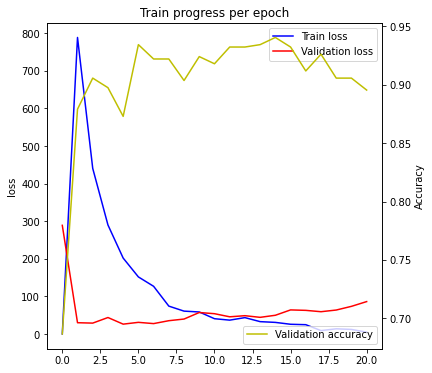

In [54]:
plot_train_progress(results_per_epoch)

## Prepare final model for Test data

### Train selected model (Classifier-2) on all data, for 12 epochs and save model

In [55]:
gc.collect()
torch.cuda.empty_cache()
# torch.cuda.reset_accumulated_memory_stats()

In [56]:
#Train configuration

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

model = BertAndFeaturesForSequenceClassification(10, model_name, num_classes=2)
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)
loss_function = nn.CrossEntropyLoss()

Device: cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
PERFORMANCE_CSV_PATH = path_output / 'final_model_for_test_train_stats.csv' 

if TRAIN_MODEL_FINAL == 'Train':
  NUMBER_OF_EPOCHS_TO_TRAIN = 14

  results_per_epoch = pd.DataFrame(columns=['epoch', 'train_loss', 'validation_loss', 'validation_accuracy'])
  best_validation_accuracy = 0

  # test initial model performance
  epoch = 0
  print(f'Epoch {epoch}')
  validation_loss, validation_accuracy = evaluate_results(model, validation_unified_dl)
  train_loss = 0
  results_per_epoch = results_per_epoch.append({'epoch': epoch, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
  print(results_per_epoch)
  results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

  # Train loop
  for epoch in tqdm(range(NUMBER_OF_EPOCHS_TO_TRAIN)):
    print(f'Epoch {epoch+1}')
    train_loss = train_epoch(model, full_unified_dl, optim, loss_function)
    validation_loss, validation_accuracy = evaluate_results(model, validation_unified_dl)
    results_per_epoch = results_per_epoch.append({'epoch': epoch+1, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
    print(results_per_epoch)
    results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

    # # if better model:
    # if validation_accuracy > best_validation_accuracy:
    #   best_validation_accuracy = validation_accuracy
    #   model_path = path_output / Path('final_model_for_test.pickle')
    #   torch.save(model.state_dict(), model_path)

  model_path = path_output / Path('final_model_for_test.pickle')
  torch.save(model.state_dict(), model_path)

else:
  # print('Loading model state from disk')
  # MODEL_PATH = path_output / Path('final_model_for_test.pickle')
  # model_state_dict = torch.load(MODEL_PATH)
  # model.load_state_dict(model_state_dict)
  results_per_epoch = pd.read_csv(PERFORMANCE_CSV_PATH)

#### Classifier train performance

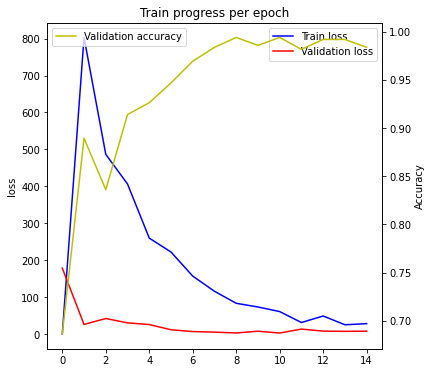

In [58]:
plot_train_progress(results_per_epoch)

## Run on test data (Last day)

### Download test data

In [85]:
data_path_test = Path('/content/drive/MyDrive/colab_data/aml_hw4/test_data.tsv')

data_test = pd.read_csv(data_path_test, sep='\t', lineterminator='\n', names=('id', 'alias', 'text', 'date_time', 'label'))
print(data_test.head(5))

                   id            alias  \
0  768083669550366720  realDonaldTrump   
1  768097204376510464  realDonaldTrump   
2  768119463421943808  realDonaldTrump   
3  768125054584393729  realDonaldTrump   
4  768196613680398336  realDonaldTrump   

                                                text              date_time  \
0  It is being reported by virtually everyone, an...  2016-08-23 16:53:11\r   
1  Hillary Clinton strongly stated  that there wa...  2016-08-23 17:46:58\r   
2  President Obama should have gone to Louisiana ...  2016-08-23 19:15:25\r   
3  Join me in Tampa, Florida- tomorrow at 1pmE! T...  2016-08-23 19:37:38\r   
4  In Austin, Texas with some of our amazing Bord...  2016-08-24 00:21:59\r   

   label  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  


### Cleanup Test dataset - date time Remove \\r, remove label column

In [86]:
data_test.date_time = data_test.date_time.replace({r'\r': ''}, regex=True)
data_test = data_test.drop('label', axis=1)

### Add attributes to test dataframe

In [87]:
print('Before:')
data_test.head(5)

Before:


id            alias  \
0  768083669550366720  realDonaldTrump   
1  768097204376510464  realDonaldTrump   
2  768119463421943808  realDonaldTrump   
3  768125054584393729  realDonaldTrump   
4  768196613680398336  realDonaldTrump   

                                                text            date_time  
0  It is being reported by virtually everyone, an...  2016-08-23 16:53:11  
1  Hillary Clinton strongly stated  that there wa...  2016-08-23 17:46:58  
2  President Obama should have gone to Louisiana ...  2016-08-23 19:15:25  
3  Join me in Tampa, Florida- tomorrow at 1pmE! T...  2016-08-23 19:37:38  
4  In Austin, Texas with some of our amazing Bord...  2016-08-24 00:21:59

In [88]:
# Apply enrichment
data_test = add_custom_atts_to_df(data_test)

Adding quote_retweet attribute


  0%|          | 0/867 [00:00<?, ?it/s]

Adding percent_caps attribute


  0%|          | 0/867 [00:00<?, ?it/s]

Adding contains_url attribute


  0%|          | 0/867 [00:00<?, ?it/s]

Adding hashtag_count attribute


  0%|          | 0/867 [00:00<?, ?it/s]

Adding date/time attributes


  0%|          | 0/867 [00:00<?, ?it/s]

#### Fix dtypes for all attributes:

In [89]:
# Fix dtypes

print(f'dtypes before: {data_test.dtypes}')
data_test = data_test.astype({'text': 'string', 
                   'date_time': 'object', 
                  #  'lang': 'category', 
                   'quote_retweet': 'bool',
                   'percent_caps': 'float32',
                   'contains_url': 'bool',
                   'hashtag_count': 'int16',
                   'year': 'int16',
                   'month': 'int16',
                   'day': 'int16',
                   'hour': 'int16',
                   'minute': 'int16',
                   'weekday': 'category'})
print()
print(f'dtypes after: {data_test.dtypes}')



dtypes before: id                 int64
alias             object
text              object
date_time         object
quote_retweet       bool
percent_caps     float64
contains_url        bool
hashtag_count      int64
year               int64
month              int64
day                int64
hour               int64
minute             int64
weekday            int64
dtype: object

dtypes after: id                  int64
alias              object
text               string
date_time          object
quote_retweet        bool
percent_caps      float32
contains_url         bool
hashtag_count       int16
year                int16
month               int16
day                 int16
hour                int16
minute              int16
weekday          category
dtype: object


### Create manual feature dataset for pytorch

In [90]:
manual_classification_features = list(data_test.columns)
del manual_classification_features[0:4]
data_for_classification_test = data_test[manual_classification_features]

manual_features_ds_test = ManualFeaturesDataset(scaler.transform(data_for_classification_test), label_encoder=label_encoder)


### Preprocess text for lang model

In [91]:
# preprocess - clean tweets, replace [urls, hashtags, names], update labels to numbers

def preprocess_text_for_bart(string_list):
    preprocessed_text_list = pd.Series(string_list).copy()
    
    # TODO: preprocess here!
    
    return preprocessed_text_list


def add_bart_preprocessed_column_to_df(dataframe):
  dataframe.loc[:, 'text_for_lang_model'] = preprocess_text_for_bart(dataframe.loc[:, 'text'])
  # TODO: need to add cleanup logic here!

  return dataframe


In [92]:
data_test = add_bart_preprocessed_column_to_df(data_test)

data_test.head()

id            alias  \
0  768083669550366720  realDonaldTrump   
1  768097204376510464  realDonaldTrump   
2  768119463421943808  realDonaldTrump   
3  768125054584393729  realDonaldTrump   
4  768196613680398336  realDonaldTrump   

                                                text            date_time  \
0  It is being reported by virtually everyone, an...  2016-08-23 16:53:11   
1  Hillary Clinton strongly stated  that there wa...  2016-08-23 17:46:58   
2  President Obama should have gone to Louisiana ...  2016-08-23 19:15:25   
3  Join me in Tampa, Florida- tomorrow at 1pmE! T...  2016-08-23 19:37:38   
4  In Austin, Texas with some of our amazing Bord...  2016-08-24 00:21:59   

   quote_retweet  percent_caps  contains_url  hashtag_count  year  month  day  \
0          False          0.01         False              0  2016      8   23   
1          False          0.06         False              0  2016      8   23   
2          False          0.04         False              0  2016      8   23   
3          False          0.13          True              0  2016      8   23   
4          False          0.11          True              0  2016      8   24   

   hour  minute weekday                                text_for_lang_model  
0    16      53       1  It is being reported by virtually everyone, an...  
1    17      46       1  Hillary Clinton strongly stated  that there wa...  
2    19      15       1  President Obama should have gone to Louisiana ...  
3    19      37       1  Join me in Tampa, Florida- tomorrow at 1pmE! T...  
4     0      21       2  In Austin, Texas with some of our amazing Bord...

### Tokenization

In [94]:
# get only relevant data as lists

def get_texts_for_lang_model(dframe, text_col_name):
  return dframe[text_col_name].tolist()


#Get texts and labels
test_texts = get_texts_for_lang_model(data_test, 'text_for_lang_model')

# Tokenize texts
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [95]:
len(test_encodings['input_ids'])

867

### Prepare test dataset

In [96]:
# standalone datasets - attributes and text
manual_features_nl_ds_test = ManualFeaturesDataset(data_for_classification_test)
text_nl_ds_test = TextClassificationDataset(test_encodings)

# full dataset
full_unified_ds_test = TextAndAttributesClassificationDataset(text_nl_ds_test, manual_features_nl_ds_test, label_encoder=label_encoder)

# Data loaders
full_unified_dl_test = torch.utils.data.DataLoader(full_unified_ds_test, batch_size=BATCH_SIZE)

### Prepare model and load state

#### Load Model config

In [97]:
# configuration

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

print('Loading model state from disk')
MODEL_PATH = path_output / Path('final_model_for_test.pickle')
model_state_dict = torch.load(MODEL_PATH)
model.load_state_dict(model_state_dict)
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)
loss_function = nn.CrossEntropyLoss()


Device: cuda
Loading model state from disk


#### Inference function

In [98]:
def scores_to_class(scores):
  '''
  Gets a matrix with score per class, returns the class (argmax)
  '''
  classes = scores.argmax(axis=1).tolist()
  return classes


def predict(model, test_dl):
  predictions = []
  model.train(False)

  with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dl)):
      features = batch['features'].to(device)
      input_ids = batch['text_encodings']['input_ids'].to(device)
      attention_mask = batch['text_encodings']['attention_mask'].to(device)

      outputs = model(features, input_ids, attention_mask=attention_mask)
      predictions += scores_to_class(outputs)

  predictions = np.array(predictions)
  return predictions


#### Predict

In [99]:
test_predictions = predict(model, full_unified_dl_test)
test_predictions = label_encoder.inverse_transform(test_predictions)

0it [00:00, ?it/s]

In [102]:
data_test['prediction'] = test_predictions
data_test_for_export = data_test[['id', 'alias', 'text', 'date_time', 'prediction']]
data_test_for_export.head()

id            alias  \
0  768083669550366720  realDonaldTrump   
1  768097204376510464  realDonaldTrump   
2  768119463421943808  realDonaldTrump   
3  768125054584393729  realDonaldTrump   
4  768196613680398336  realDonaldTrump   

                                                text            date_time  \
0  It is being reported by virtually everyone, an...  2016-08-23 16:53:11   
1  Hillary Clinton strongly stated  that there wa...  2016-08-23 17:46:58   
2  President Obama should have gone to Louisiana ...  2016-08-23 19:15:25   
3  Join me in Tampa, Florida- tomorrow at 1pmE! T...  2016-08-23 19:37:38   
4  In Austin, Texas with some of our amazing Bord...  2016-08-24 00:21:59   

  prediction  
0    android  
1    android  
2    android  
3     iphone  
4     iphone

In [106]:
data_test_for_export.to_csv(path_output / 'test_with_predictions.tsv', sep='\t', header=False, index=False)